##Import

In [1]:
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests

## Model

In [2]:
# only use the feature extraction part 
vgg = models.vgg19(pretrained=True).features

# keep the model's parameter value
for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
def load_image(img_path, max_size=500, shape=None):
    
    # make sure image in "RGB" format
    image = Image.open(img_path).convert('RGB')
    size = max(image.size)

    if max(image.size) > max_size:
        size = max_size
    
    # keep Style Image same size as Content Image
    if shape is not None:
        size = shape
 
    image_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), 
                                             (0.5, 0.5, 0.5))])
    
    # unsqueeze to add the batch_size dimension
    return image_transform(image).unsqueeze(0)

## Load image

In [5]:
content_url = 'https://pix10.agoda.net/geo/city/3987/1_3987_02.jpg?s=1920x822'
content_image_path = requests.get(content_url, stream = True).raw


style_url = 'https://static1.squarespace.com/static/56e8182ba3360ced7374b83b/t/5ad01b9ef950b750de85ed3e/1523588024555/Starry+Night.png?format=1500w'
style_image_path = requests.get(style_url, stream = True).raw


content_image = load_image(content_image_path).to(device)
# ensure Style Image match the size of Content Image
style_image = load_image(style_image_path, shape=content_image.shape[2:]).to(device)

## Display content and style image

In [6]:
def im_convert(tensor):
    '''
        Convert Tensor to displable format
    '''
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    return image

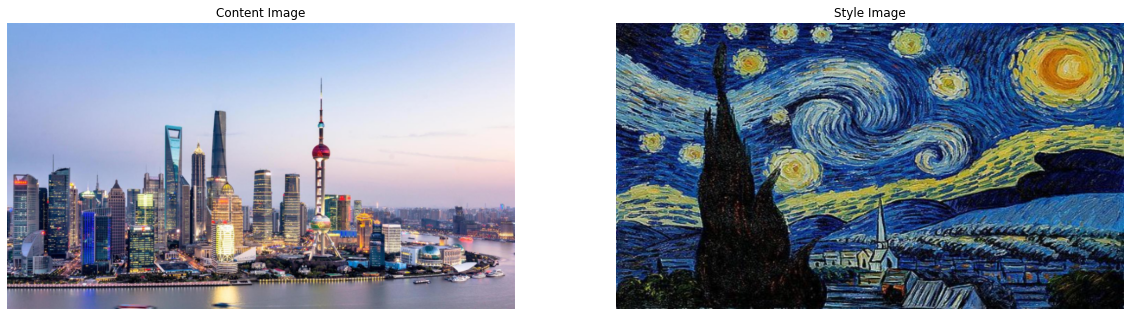

In [7]:
#############     Display Content and Style for 5 seconds ##############
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content_image))
ax1.axis("off")
ax1.title.set_text('Content Image')
ax2.imshow(im_convert(style_image))
ax2.axis("off")
ax2.title.set_text('Style Image')
plt.show()

## Feature extraction

In [8]:
def get_features_map(image, model):
    # layer number and name mapping
    layers = {'0': 'conv1_1',
              '5': 'conv2_1', 
              '10': 'conv3_1', 
              '19': 'conv4_1',
              '21': 'conv4_2',  # Content Representation
              '28': 'conv5_1'}
        
    features = {}

    for layer_number, layer in model._modules.items():
        image = layer(image)
        if layer_number in layers:
            features[layers[layer_number]] = image
            
    return features
  

content_image_features = get_features_map(content_image, vgg)
style_image_features = get_features_map(style_image, vgg)

## Gram matrix

In [9]:
def gram_matrix(tensor):
    _, depth, height, weight = tensor.size()
    tensor = tensor.view(depth, height * weight)
    gram = torch.mm(tensor, tensor.t())
    return gram

style_image_grams = {layer: gram_matrix(style_image_features[layer]) for layer in style_image_features}

## Layers weights

In [10]:
# weights for each layer
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e4  # beta

## Generated image

In [11]:
generated_image = content_image.clone().requires_grad_(True).to(device)

## Training in action

In [12]:
optimizer = torch.optim.Adam([generated_image], lr=0.003)

epochs = 10000
show_every = 250

plt.ion()
plt.show()

Total loss:  934350.0625
Iteration:  0


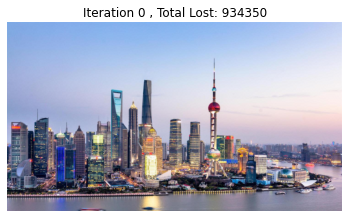

Total loss:  30110.73046875
Iteration:  250


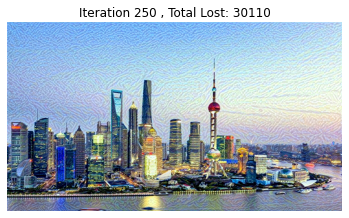

Total loss:  22013.728515625
Iteration:  500


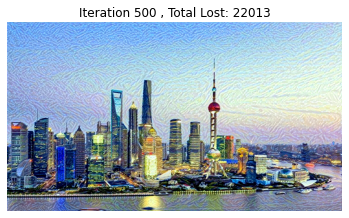

Total loss:  18347.326171875
Iteration:  750


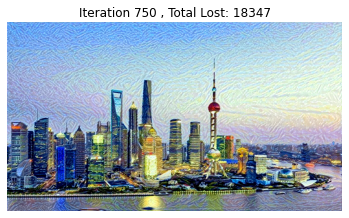

Total loss:  15788.609375
Iteration:  1000


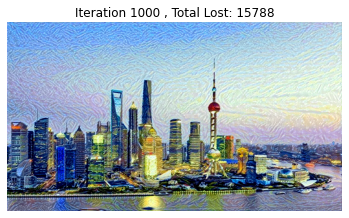

In [ ]:
for e in range(epochs):
    generated_image_features = get_features_map(generated_image, vgg)
    content_loss = torch.mean((generated_image_features['conv4_2'] - content_image_features['conv4_2'])**2)
  
    style_loss = 0
  
    # caculate style loss
    for layer in style_weights:
        generated_image_feature = generated_image_features[layer]
        generated_image_gram = gram_matrix(generated_image_feature)
        style_image_gram = style_image_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((generated_image_gram - style_image_gram)**2)
        _, d, h, w = generated_image_feature.shape
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
  
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
  
    
    if  e % show_every == 0:
        print('Total loss: ', total_loss.item())
        print('Iteration: ', e)
        plt.imshow(im_convert(generated_image))
        plt.title('Iteration %i , Total Lost: %i' % (e, total_loss.item()))
        plt.axis("off")
        plt.pause(0.01)

(-0.5, 559.5, 399.5, -0.5)

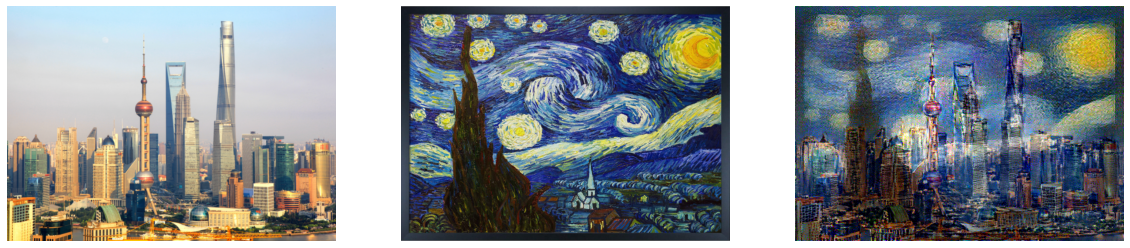

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content_image))
ax1.axis('off')
ax2.imshow(im_convert(style_image))
ax2.axis('off')
ax3.imshow(im_convert(generated_image))
ax3.axis('off')
# turn the interactive mode off
plt.ioff()
plt.show()